In [87]:
import os
import glob
import gzip
import gffutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam 
import seaborn as sns

from collections import defaultdict
from IPython.display import display, Markdown

### This notebook visualizes the Differentially Expressed Genes detected using edgeR package

__Required input__  
* Transcript counts TSV file
* File containing differentially expressed genes outputted by notebook `deg_using_edgeR.ipynb` 

--------------

### Summarize differential expression 
__Using the provided sample-level counts (RNAseq_counts) and sample sheet (calico_data_challenge_samplesheet.tsv) answer the following questions:__
* Which genes are differentially expressed based on,
    * Age 
    * Genotype
    * genotype-specific aging.

Gene expressions are highly differ between age groups than genotype. I have generated DEG file for multiple pairwise comparison using `deg_using_edgeR.ipynb` notebook.  

In this notebook, I plotted these DEG heatmaps for each comparison and we can clearly see the contrast between *Age 0 hour* and *Age 20, Age 40*.  
However, there doesn't seem to be much variation between *Age 20 hour* and *Age 40 hour*. Unfortunately, I haven not been able to probe genotyp-specific aging although it can be easily generated using the `deg_using_edgeR.ipynb` notebook.  
* What do these genes have in common?

I manually queried the ontoloy on https://www.yeastgenome.org and it seems top DEG genes are commonly related to `vegetative growth`, specially decreased growth in both *Age 20 hour* and *Age 40 hour*.
* If you had more time, what aspect of this dataset would you explore to further address the motivating question or caveats that may exist.  

If I had more time, i would inspect the difference between replicates and outlier genes. Also I would like to explore more how the counts are generated, such as transcript mappings and multi-mapping strategy.
There are certain genes that have abnormally high expressed, such as LSR1. From the yeast ontology, LSR1 is a component of the spliceosome and related to splicing so this gene maybe need to be removed. 


In [4]:
def read_rnaseq_counts(infile):
    '''
        Read in Transcript counts file and remove un-used rows and rename columns
    '''
    col_name = infile.split('/')[-1][:-len('.counts')]
    df = pd.read_csv(infile, sep='\t', header=None).rename(columns={0: 'gene', 1: col_name})
    # Drop non-applicable rows
    labels_to_drop = ['__no_feature', '__ambiguous', '__too_low_aQual', 
                      '__not_aligned', '__alignment_not_unique']
    return df.set_index('gene').drop(labels_to_drop, axis=0)


def plot_heatmap(df, ax, title):
    if not df.empty:
        # Normalize gene rows to (0 - 1) range for high contrast
        norm_df = df.apply(lambda x: x/max(x), axis=1)
        sns.heatmap(norm_df, cmap='coolwarm', ax=ax)
    ax.set_title(title)


def plot_deg_gene_matrix(combined_counts_df, col_order, deg_file, fold_change_threshold=3):
    # Diff Exp Genes from edgeR
    deg_df = pd.read_csv(deg_file, sep='\t').set_index('genes')
    up_deg_df = deg_df[deg_df['logFC'] >= fold_change_threshold].sort_values(by='logFC', ascending=False)
    down_deg_df = deg_df[deg_df['logFC'] <= -fold_change_threshold].sort_values(by='logFC')

    grp1_name, grp2_name = deg_file[:-len('.tsv')].split('_vs_')

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    plot_heatmap(combined_counts.loc[down_deg_df.index, col_order], ax[0], title='Hyper expressed in {}'.format(grp1_name))
    plot_heatmap(combined_counts.loc[up_deg_df.index, col_order], ax[1], title='Hyper expressed in {}'.format(grp2_name))
    plt.show()


### Read RNA-seq counts data

In [60]:
rnaseq_counts_files = sorted(glob.glob('../rna_counts/*'))
combined_counts = pd.concat([read_rnaseq_counts(rnaseq_count) for rnaseq_count in rnaseq_counts_files], axis=1).sort_index()

### Create Sample grouping based on Strain and Age

In [6]:
strain_group = defaultdict(list)
age_group = defaultdict(list)
for sample in combined_counts.columns:
    strain_group[sample.split('_')[0]].append(sample)
    age_group[sample.split('_')[1]].append(sample)


age_ordered_cols = []
for k, v in age_group.items():
    age_ordered_cols.extend(v)
    
strain_ordered_cols = []
for k, v in strain_group.items():
    strain_ordered_cols.extend(v)

### Summary comparison of DEG between age

Here I have compared the DEG result of `Age_0 VS Age_20` and `Age_0 VS Age_40`
Below is 10 out of top 20 DEG that is common between 2 comparisons. I have queried the gene ontology from https://www.yeastgenome.org and the common theme is   
__below 10 genes when over expressed leads to slow vegetative growth rate__.  

	Large-scale Survey result:

| Gene    | Overexpression                     |
|---------|------------------------------------|
| YIL101C | vegetative growth: decreased       |
| YNL194C | vegetative growth: decreased       |
| YDR536W | respiratory growth: increased rate |
| YJL116C | vegetative growth: decreased       |
| YGR213C | vegetative growth: decreased       |
| YFL014W | vegetative growth: decreased       |
| YPR160W | vegetative growth: decreased       |
| YOR100C | filamentous growth: increased      |

In [89]:
deg_age_0_vs_20 = pd.read_csv('age_0_vs_age_20.tsv', sep='\t', index_col=0)
deg_age_0_vs_40 = pd.read_csv('age_0_vs_age_40.tsv', sep='\t', index_col=0)
deg_common = set(deg_age_0_vs_20.index.tolist()).intersection(set(deg_age_0_vs_40.index.tolist()))
display(Markdown('### There are {} common genes differentially expressed between Age 0 - 20, 40 hours'.format(len(deg_common))))
deg_age_0_vs_20.loc[common].sort_values(by='logFC', ascending=False).head()

### There are 29 common genes differentially expressed between Age 0 - 20, 40 hours

,logFC,logCPM,LR,PValue,FDR
genes,,,,,
YIL101C,4.398916,4.670905,326.674212,5.095178e-73,3.073921e-69
YNL194C,4.069232,2.506346,230.796109,3.996923e-52,4.822687e-49
YOL052C-A,4.006442,3.302147,253.259409,5.056817e-57,1.016926e-53
YDR536W,3.907276,0.849656,144.391224,2.917806e-33,7.334635e-31
YEL039C,3.686510,2.319349,196.927667,9.779332e-45,5.899871e-42


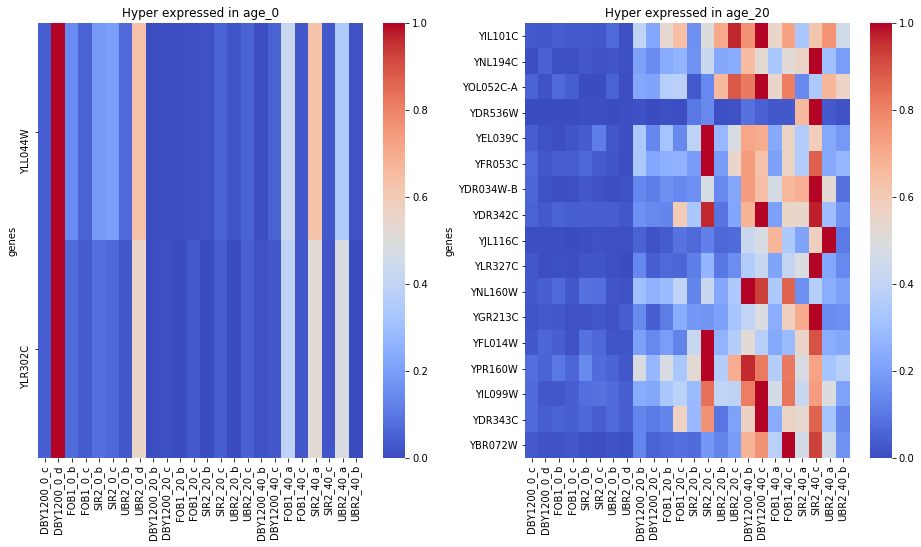

In [66]:
plot_deg_gene_matrix(combined_counts, age_ordered_cols, 'age_0_vs_age_20.tsv', fold_change_threshold=3)

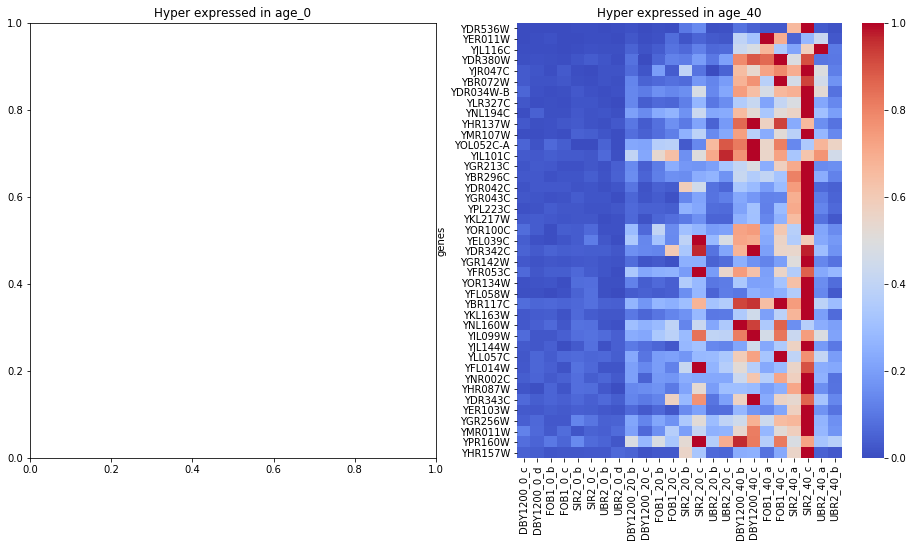

In [69]:
plot_deg_gene_matrix(combined_counts, age_ordered_cols, 'age_0_vs_age_40.tsv', fold_change_threshold=3)